# Определение возраста покупателей

**Описание проекта**


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


1. Исследовательский анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и нахождение её качества.

## Исследовательский анализ данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Размер выборки: 7591


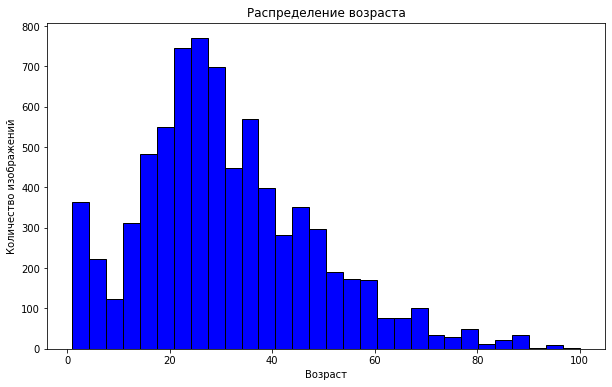

Found 7591 validated image filenames.


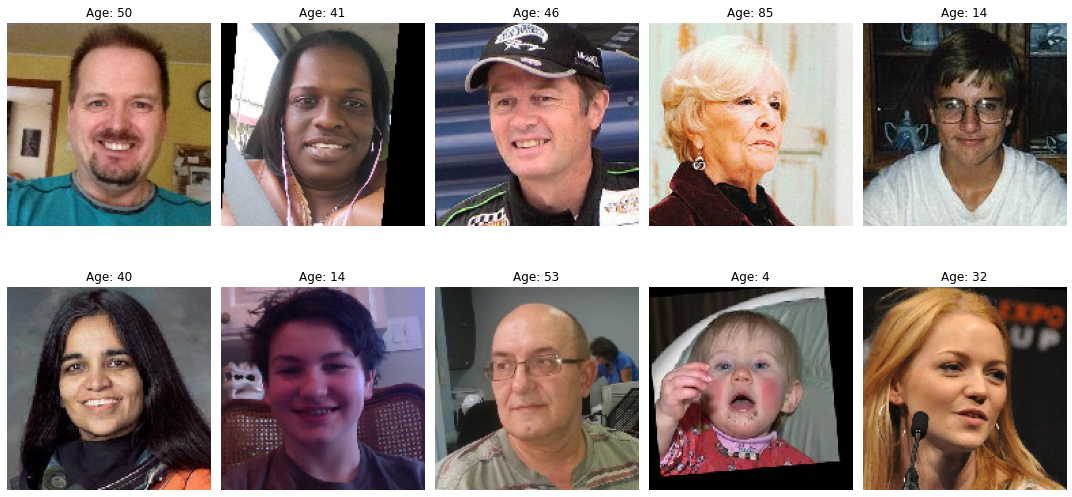

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка CSV-файла с данными
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()
data.info()
# Посмотрим на размер выборки
print("Размер выборки:", len(data))

# Построим график распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(data['real_age'], bins=30, color='blue', edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

# Выведем на экран несколько фотографий
datagen = ImageDataGenerator(rescale=1. / 255)
data_flow = datagen.flow_from_dataframe(data, directory='/datasets/faces/final_files/', x_col='file_name',
                                        y_col='real_age', target_size=(150, 150), batch_size=32,
                                        class_mode='raw', seed=12345)
images, labels = next(data_flow)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Совет: </b> Не забывай про методы первичного анализа (head и info), которые нужно использовать после загрузки файла.
</div>

<div class="alert alert-block alert-warning">
<b>Добавила</b> 
</div>

In [2]:
print("Средний возраст:", data['real_age'].mean())
print("Минимальный возраст:", data['real_age'].min())
print("Максимальный возраст:", data['real_age'].max())
print("Количество фотографий для каждого возраста:")
print(data['real_age'].value_counts().sort_index())

Средний возраст: 31.20115926755368
Минимальный возраст: 1
Максимальный возраст: 100
Количество фотографий для каждого возраста:
1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: real_age, Length: 97, dtype: int64


В данных присутствуют 7591 фотографии.

Больше всего фотографий в диапазоне от 20 до 40 лет. 

Средний возраст: 31.20115926755368

Минимальный возраст: 1

Максимальный возраст: 100

Осложнением является тот факт, что на фотографиях присутствуют объекты, которые закрывают лицо: рука, посторонние предметы, очки, головные уборы.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='validation',
      seed=12345)

    return test_gen_flow

def create_model(input_shape): 
    optimizer = Adam(learning_rate = 0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False) 
 
    model = Sequential() 
 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 68s - loss: 190.7636 - mae: 10.3577 - val_loss: 308.3247 - val_mae: 13.0449
Epoch 2/10
356/356 - 55s - loss: 113.0638 - mae: 8.0843 - val_loss: 187.8488 - val_mae: 10.1877
Epoch 3/10
356/356 - 54s - loss: 82.2380 - mae: 6.9484 - val_loss: 119.4159 - val_mae: 8.7027
Epoch 4/10
356/356 - 54s - loss: 69.7660 - mae: 6.3998 - val_loss: 94.0168 - val_mae: 7.2894
Epoch 5/10
356/356 - 54s - loss: 55.2982 - mae: 5.6983 - val_loss: 99.2775 - val_mae: 7.5375
Epoch 6/10
356/356 - 54s - loss: 48.6029 - mae: 5.3277 - val_loss: 89.4416 - val_mae: 7.1222
Epoch 7/10
356/356 - 40s - loss: 38.3212 - mae: 4.7765 - val_loss: 130.0848 - val_mae: 8.7996
Epoch 8/10
356/356 - 39s - loss: 34.5907 - mae: 4.4706 - val_loss: 81.8672 - val_mae: 6.7223
Epoch 9/10
356/356 - 39s - loss: 27.3028 - mae: 3.9790 - val_loss: 86.2713 - val_mae: 7.0369
Epoch 10/10
356/356 - 50s - loss: 22.5454 - mae: 3.6375 - val_loss: 98.0358 - val_mae: 7.5092

119/119 - 10s - loss: 98.0358 - mae: 7.5092
Test MAE: 7.509

```

## Анализ обученной модели

За 10 эпох обучения удалось уменьшить метрику MAE с 10 до 7.5 на тренировочной выборке. 

Обученная модель позволяет с достаточно высокой точностью предсказывать возраст людей на фотографии. Значения МАЕ 7.2 - неплохой показатель.

Использование GPU и нейронных сетей позволяет эффективно обработать большое количество информации с высокой точностью.

<div class="alert alert-block alert-warning">
Думаю, что модель позволяет решить поставленные задачи. Кроме того, с помощью этой модели могут быть решены следующие задачи:
    
1. Персонализированный маркетинг. Модель может помочь анализировать возраст покупателей и предлагать им товары и акции, которые наиболее интересны для их возрастной группы. Это позволит улучшить опыт покупателей и увеличить конверсию продаж.

2. Анализ покупок и предпочтений. Зная возраст клиентов, супермаркет может проводить более детальный анализ покупок и предпочтений разных возрастных групп. Это поможет оптимизировать ассортимент товаров, рекламные кампании и мероприятия.

3. Контроль продажи алкоголя и ограниченных товаров. Модель может быть использована для автоматической проверки возраста покупателя перед продажей алкоголя и других ограниченных товаров. Это повысит точность контроля и снизит риски нарушения законодательства.
</div>